# Synthetic Data Generation

We will use a pre-tuned model to produce data. The model output should be a 3D array with condition, signaling node and time point for dimensions. The model output will be sub-sampled to produce the synthetic dataset.

In [1]:
import torch
import numpy
import LEMBAS_generator.bionetwork as bionetwork
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from scipy.stats import pearsonr

## Run the pre-trained model

Run pre-trained model to produce synthetic data that are going to be used to evaluate the toy model. We will store both `fullYfull` which is the Y for all model states as well as the `X` that we used.

Prepare `X` and `fullYFull` for sub-sampling. `X` should be a matrix with Drug and Cell line as indexes and Targeted genes as columns. `fullYFull` should be matrix with Drug, Cell line, and Gene as indexes and Time points as columns.

The Cell line is also simulated by randomizing the bias randomly for each cell line and then run the model.

In [2]:
# Setup parameters
N = 200
inputAmplitude = 3
projectionAmplitude = 1.2
seed = 123
torch.manual_seed(seed)
numpy.random.seed(seed)

# Cell type spliting parameters
n_celllines = 6
celltype_factor = 1
split_1 = 2
split_2 = 2
split_3 = 2

# Load network
networkList, nodeNames, modeOfAction = bionetwork.loadNetwork('data/KEGGnet-Model.tsv')
annotation = pandas.read_csv('data/KEGGnet-Annotation.tsv', sep='\t')
bionetParams = bionetwork.trainingParameters(iterations = 150, clipping=1, leak=0.01)

inName = annotation.loc[annotation['ligand'],'code'].values
outName = annotation.loc[annotation['TF'],'code'].values
inName = numpy.intersect1d(nodeNames, inName)
outName = numpy.intersect1d(nodeNames, outName)

synthetic_data_combined = []
X_combined = []
b_celltype = pandas.DataFrame()

# Generate data for 6 different cell lines
cnt = 0  # cell line counter
# Generate first gen
for j in range(split_1):
    celltype = cnt
    parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_factor=celltype_factor, b_celltype_old = None)
    parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

    # Generate data
    torch.manual_seed(123)
    X = torch.zeros(N, len(inName), dtype=torch.double)
    for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
        X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
        X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)

    Y, YfullRef, fullYFull, b_celltype_array_1 = parameterizedModel(X)

    # Generate second gen
    for k in range(split_2):
        celltype = cnt
        parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_factor=celltype_factor, b_celltype_old = b_celltype_array_1)
        parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

        # Generate data
        torch.manual_seed(123)
        X = torch.zeros(N, len(inName), dtype=torch.double)
        for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
            X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
            X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)

        Y, YfullRef, fullYFull, b_celltype_array_2 = parameterizedModel(X)
        # Generate third gen
        for l in range(split_3):
            cell_line_name = f"CL_{cnt}"
            celltype = cnt
            parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_factor=celltype_factor, b_celltype_old = b_celltype_array_2)
            parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

            # Generate data
            torch.manual_seed(123)
            X = torch.zeros(N, len(inName), dtype=torch.double)
            for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
                X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
                X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)

            Y, YfullRef, fullYFull, b_celltype_array = parameterizedModel(X)
            fullYFull = fullYFull.detach()

            # Transform fullYFull to a dataframe
            fullYFull_np = fullYFull.numpy()  # dimensions: conditions, node names, states

            dim1, dim2, dim3 = fullYFull_np.shape

            reshaped_array = fullYFull_np.reshape(dim1 * dim2, dim3)

            synthetic_data = pandas.DataFrame(reshaped_array)

            #drug_names = [f"D_{i}" for i in range(1, dim1 + 1)]
            drug_names = ['DMSO'] + [f"D_{i}" for i in range(1, dim1)]
            index = pandas.MultiIndex.from_product([drug_names, [cell_line_name], nodeNames], names=['Drug', 'Cell_line', 'Signaling Node'])
            synthetic_data.index = index

            synthetic_data_combined.append(synthetic_data)
            
            # Transform X to a dataframe
            X = X.numpy()
            X = pandas.DataFrame(X)
            index = pandas.MultiIndex.from_product([drug_names, [cell_line_name]], names=['Drug', 'Cell_line'])
            X.index = index
            X.columns = inName
            X_combined.append(X)
            
            # Transform and store the b_celltype
            b_celltype_df = pandas.DataFrame(b_celltype_array, columns=['Value'])
            b_celltype_df['Cell_line'] = cell_line_name
            b_celltype_df['Node'] = nodeNames
            b_celltype = pandas.concat([b_celltype, b_celltype_df], axis=0)
            fullYFull = fullYFull.detach()
            
            cnt += 1
            
synthetic_data = pandas.concat(synthetic_data_combined)
X = pandas.concat(X_combined)
b_celltype.set_index(['Cell_line', 'Node'], inplace=True)

# Randomly sub-sample the cell lines
unique_cell_lines = b_celltype.index.get_level_values('Cell_line').unique()
selected_cell_lines = numpy.random.choice(unique_cell_lines, 6, replace=False)
synthetic_data = synthetic_data[synthetic_data.index.get_level_values('Cell_line').isin(selected_cell_lines)]
X = X[X.index.get_level_values('Cell_line').isin(selected_cell_lines)]
b_celltype = b_celltype[b_celltype.index.get_level_values('Cell_line').isin(selected_cell_lines)]

display(synthetic_data.head())
display(X.head())
display(b_celltype.head())

0         1         2         3    \
Drug Cell_line Signaling Node                                           
DMSO CL_0      O00206         -0.066264 -0.066304 -0.066305 -0.066305   
               O14492         -0.027248 -0.021700 -0.021716 -0.021716   
               O14511         -0.041102 -0.041102 -0.041102 -0.041102   
               O14640         -0.000315 -0.000499 -0.000521 -0.000521   
               O14727         -0.037680 -0.037683 -0.037683 -0.037683   

                                    4         5         6         7    \
Drug Cell_line Signaling Node                                           
DMSO CL_0      O00206         -0.066305 -0.066305 -0.066305 -0.066305   
               O14492         -0.021716 -0.021716 -0.021716 -0.021716   
               O14511         -0.041102 -0.041102 -0.041102 -0.041102   
               O14640         -0.000521 -0.000521 -0.000521 -0.000521   
               O14727         -0.037683 -0.037683 -0.037683 -0.037683   

                                    8         9    ...  140  141  142  143  \
Drug Cell_line Signaling Node                      ...                       
DMSO CL_0      O00206         -0.066305 -0.066305  ...  0.0  0.0  0.0  0.0   
               O14492         -0.021716 -0.021716  ...  0.0  0.0  0.0  0.0   
               O14511         -0.041102 -0.041102  ...  0.0  0.0  0.0  0.0   
               O14640         -0.000521 -0.000521  ...  0.0  0.0  0.0  0.0   
               O14727         -0.037683 -0.037683  ...  0.0  0.0  0.0  0.0   

                               144  145  146  147  148  149  
Drug Cell_line Signaling Node                                
DMSO CL_0      O00206          0.0  0.0  0.0  0.0  0.0  0.0  
               O14492          0.0  0.0  0.0  0.0  0.0  0.0  
               O14511          0.0  0.0  0.0  0.0  0.0  0.0  
               O14640          0.0  0.0  0.0  0.0  0.0  0.0  
               O14727          0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 150 columns]

,,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug,Cell_line,,,,,,,,,,,,,,,,,,,,,
DMSO,CL_0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_1,CL_0,0.368896,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_2,CL_0,0.000000,0.59178,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_3,CL_0,0.000000,0.00000,0.472452,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_4,CL_0,0.000000,0.00000,0.000000,0.605083,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Value
Cell_line Node            
CL_0      O00206 -3.310412
          O14492 -1.373251
          O14511 -2.060817
          O14640 -0.000491
          O14727 -1.884025

In [3]:
# Check if control is properly created with all columns 0 in X
filtered_rows = X.loc['DMSO']
all_zeros = (filtered_rows == 0).all().all()
print("All columns of the rows with Drug 'DMSO' (control) are all zeros:", all_zeros)

All columns of the rows with Drug 'DMSO' (control) are all zeros: True


## Sub-sample synthetic data

Sub-sample `fullYFull` by keeping only the # most variant Drugs across Cell lines and the first 18 time points with step 3 (to ensure we reached the steady state). Select the same Conditions for `X`.

In [4]:

# Select time points
num_timesteps = 150  # Number of all time steps
num_samples = 7  # Target number of time steps
exponential_indices = numpy.logspace(0, numpy.log10(num_timesteps - 1), num=num_samples, dtype=int)
print(f'Subsampled time steps: {exponential_indices}')
exponential_indices = numpy.unique(exponential_indices)
synthetic_data_filtered = synthetic_data.iloc[:, exponential_indices]
'''
# Simple manual sampling
n_timepoints = 21
time_step = 3
synthetic_data_filtered = synthetic_data.iloc[:, :n_timepoints:time_step]
'''
n_drugs = 7  # Number of drugs other than control

# Calculate the standard deviation for each condition to keep the ones with the heighest
variation = synthetic_data_filtered.groupby('Drug').std().mean(axis=1)
top_conditions = variation.nlargest(n_drugs).index
top_conditions = top_conditions.append(pandas.Index(['DMSO']))  # Add control + n_drugs drugs

synthetic_data_filtered = synthetic_data_filtered.loc[top_conditions]
synthetic_data = synthetic_data.loc[top_conditions]
display(synthetic_data_filtered.head())
display(synthetic_data.head())

# Select the same Conditions for X
unique_conditions = synthetic_data_filtered.index.get_level_values('Drug').unique()
X_filtered = X.loc[unique_conditions]
display(X_filtered.head())

# Create X_cell based on the sample cell lines
cell_lines = X_filtered.index.get_level_values('Cell_line').unique()
X_cell = pandas.DataFrame(0, index=X_filtered.index, columns=cell_lines)

for cell_line in cell_lines:
    X_cell[cell_line] = (X_filtered.index.get_level_values('Cell_line') == cell_line).astype(int)

display(X_cell.head())

Subsampled time steps: [  1   2   5  12  28  64 149]


1         2         5         12   \
Drug  Cell_line Signaling Node                                           
D_180 CL_0      O00206         -0.066304 -0.066305 -0.066305 -0.066305   
                O14492         -0.021700 -0.021716 -0.021716 -0.021716   
                O14511         -0.041102 -0.041102 -0.041102 -0.041102   
                O14640         -0.000499 -0.000521 -0.000521 -0.000521   
                O14727         -0.037683 -0.037683 -0.037683 -0.037683   

                                     28   64   149  
Drug  Cell_line Signaling Node                      
D_180 CL_0      O00206         -0.066305  0.0  0.0  
                O14492         -0.021716  0.0  0.0  
                O14511         -0.041102  0.0  0.0  
                O14640         -0.000521  0.0  0.0  
                O14727         -0.037683  0.0  0.0

0         1         2         3    \
Drug  Cell_line Signaling Node                                           
D_180 CL_0      O00206         -0.066264 -0.066304 -0.066305 -0.066305   
                O14492         -0.027248 -0.021700 -0.021716 -0.021716   
                O14511         -0.041102 -0.041102 -0.041102 -0.041102   
                O14640         -0.000315 -0.000499 -0.000521 -0.000521   
                O14727         -0.037680 -0.037683 -0.037683 -0.037683   

                                     4         5         6         7    \
Drug  Cell_line Signaling Node                                           
D_180 CL_0      O00206         -0.066305 -0.066305 -0.066305 -0.066305   
                O14492         -0.021716 -0.021716 -0.021716 -0.021716   
                O14511         -0.041102 -0.041102 -0.041102 -0.041102   
                O14640         -0.000521 -0.000521 -0.000521 -0.000521   
                O14727         -0.037683 -0.037683 -0.037683 -0.037683   

                                     8         9    ...  140  141  142  143  \
Drug  Cell_line Signaling Node                      ...                       
D_180 CL_0      O00206         -0.066305 -0.066305  ...  0.0  0.0  0.0  0.0   
                O14492         -0.021716 -0.021716  ...  0.0  0.0  0.0  0.0   
                O14511         -0.041102 -0.041102  ...  0.0  0.0  0.0  0.0   
                O14640         -0.000521 -0.000521  ...  0.0  0.0  0.0  0.0   
                O14727         -0.037683 -0.037683  ...  0.0  0.0  0.0  0.0   

                                144  145  146  147  148  149  
Drug  Cell_line Signaling Node                                
D_180 CL_0      O00206          0.0  0.0  0.0  0.0  0.0  0.0  
                O14492          0.0  0.0  0.0  0.0  0.0  0.0  
                O14511          0.0  0.0  0.0  0.0  0.0  0.0  
                O14640          0.0  0.0  0.0  0.0  0.0  0.0  
                O14727          0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 150 columns]

O14511  O14788  O14944  O43557  O75093  O75094    O75326  \
Drug  Cell_line                                                             
D_180 CL_0          0.0     0.0     0.0     0.0     0.0     0.0  0.000000   
      CL_1          0.0     0.0     0.0     0.0     0.0     0.0  0.000000   
      CL_3          0.0     0.0     0.0     0.0     0.0     0.0  0.000000   
      CL_4          0.0     0.0     0.0     0.0     0.0     0.0  0.855909   
      CL_5          0.0     0.0     0.0     0.0     0.0     0.0  0.000000   

                 O94813  O96014  P00734  ...  Q8NHW4  Q8WWG1  Q96A98  Q96B86  \
Drug  Cell_line                          ...                                   
D_180 CL_0          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_1          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_3          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_4          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_5          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

                 Q96S42  Q99075  Q9GZV9  Q9NPF7  Q9NSA1  Q9NT99  
Drug  Cell_line                                                  
D_180 CL_0          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_1          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_3          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_4          0.0     0.0     0.0     0.0     0.0     0.0  
      CL_5          0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 101 columns]

Cell_line        CL_0  CL_1  CL_3  CL_4  CL_5  CL_6
Drug  Cell_line                                    
D_180 CL_0          1     0     0     0     0     0
      CL_1          0     1     0     0     0     0
      CL_3          0     0     1     0     0     0
      CL_4          0     0     0     1     0     0
      CL_5          0     0     0     0     1     0

### Explore Synthetic Data

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


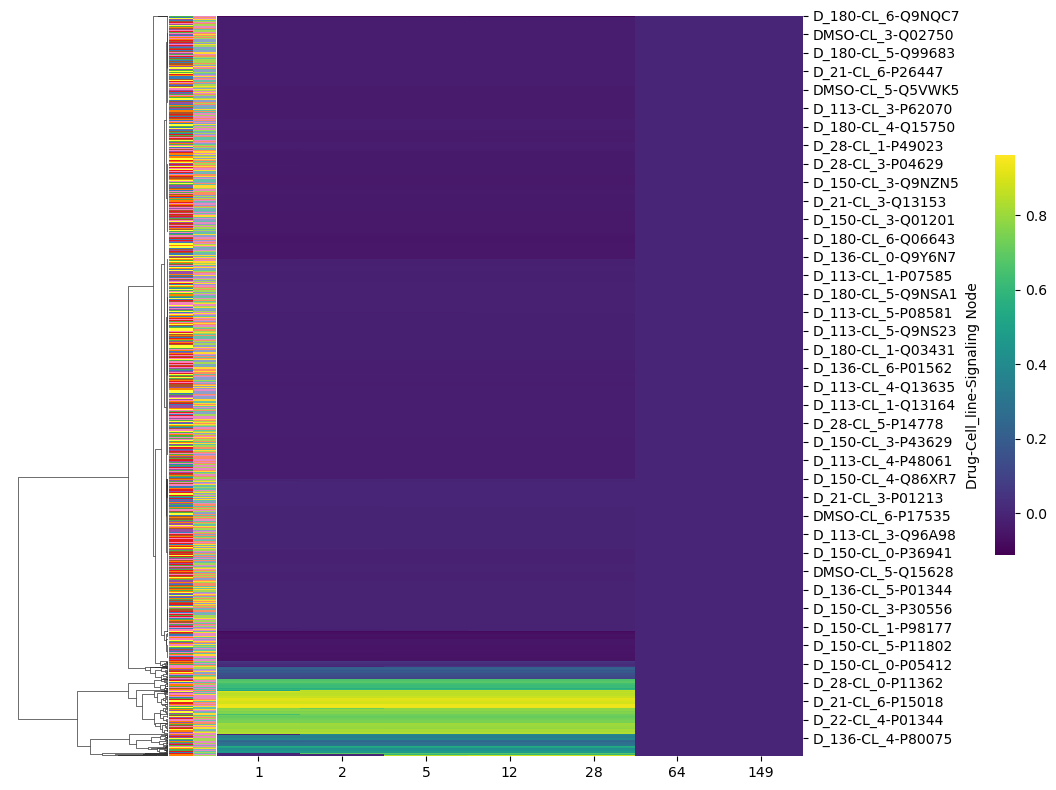

In [5]:
synthetic_data_plot = synthetic_data_filtered.copy()
annotations = synthetic_data_plot.index.to_frame(index=False)

drug_colors = sns.color_palette("Set1", len(annotations['Drug'].unique()))
cell_line_colors = sns.color_palette("Set2", len(annotations['Cell_line'].unique()))

drug_lut = dict(zip(annotations['Drug'].unique(), drug_colors))
cell_line_lut = dict(zip(annotations['Cell_line'].unique(), cell_line_colors))

row_colors = pandas.DataFrame({
    'Drug': annotations['Drug'].map(drug_lut),
    'Cell_line': annotations['Cell_line'].map(cell_line_lut)
})
drug_colors = row_colors['Drug']
cell_line_colors = row_colors['Cell_line']

sns.clustermap(
    synthetic_data_plot, 
    cmap='viridis', 
    figsize=(10, 8), 
    col_cluster=False, 
    row_colors=[drug_colors, cell_line_colors], 
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0))
plt.show()

,Drug,Cell_line,Signaling Node,Time,Value
0,D_180,CL_0,O60674,1,-0.038761
1,D_180,CL_1,O60674,1,-0.048853
2,D_180,CL_3,O60674,1,-0.007516
3,D_180,CL_4,O60674,1,-0.001746
4,D_180,CL_5,O60674,1,-0.010084


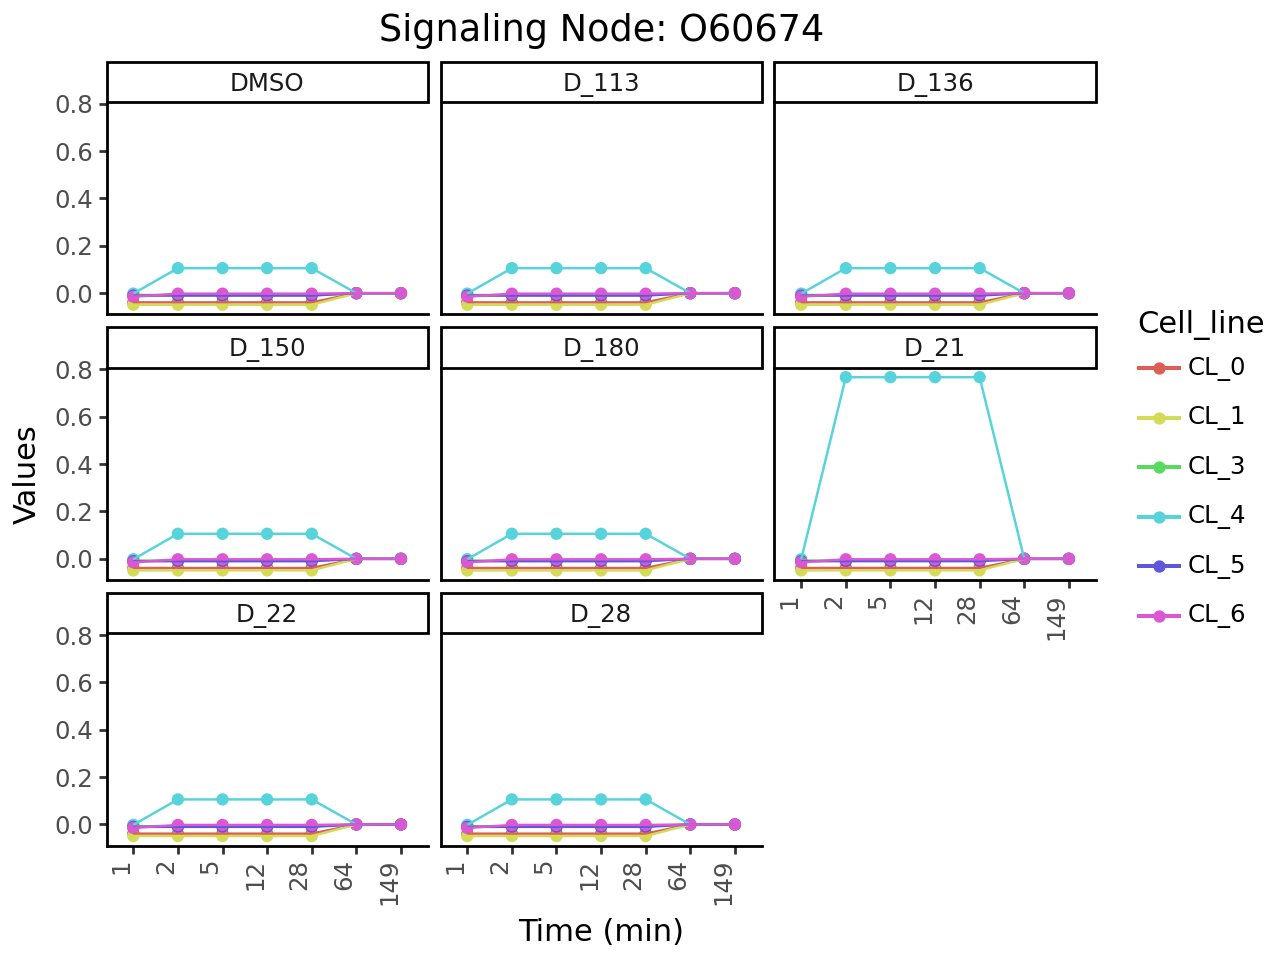

In [6]:
signaling_node = 'O60674'

idx = pandas.IndexSlice
specific_rows = synthetic_data_filtered.loc[idx[:, :, signaling_node], :]
specific_rows = specific_rows.reset_index()
specific_rows = specific_rows.melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')
display(specific_rows.head())

plot = (p9.ggplot(specific_rows, p9.aes(x='Time', y='Value', color='Cell_line', group='Cell_line'))
        + p9.geom_point()
        + p9.geom_line()
        + p9.facet_wrap('~Drug')
        + p9.labs(title=f'Signaling Node: {signaling_node}', x='Time (min)', y='Values')
        + p9.theme_classic()
        + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1)))

plot.show()

Plot the Cell line variation (correlation between average and individual cell lines).

C:\Users\kanto\AppData\Local\Temp\ipykernel_11700\823991749.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


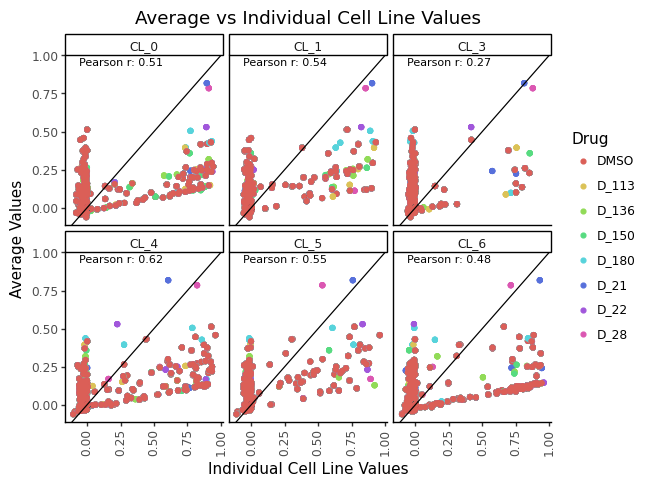

In [7]:
# Long transform the data
synthetic_data_long = synthetic_data_filtered.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')

# Calculate the average for each Drug/Time Point/Signaling Node across all Cell Lines
average_data = synthetic_data_long.groupby(['Drug', 'Time', 'Signaling Node'])['Value'].mean().reset_index()
average_data = average_data.rename(columns={'Value': 'Average'})
merged_data = pandas.merge(synthetic_data_long, average_data, on=['Drug', 'Time', 'Signaling Node'])

# Calculate Pearson correlation for each cell line against the average
def add_pearson_corr(data):
    corr, _ = pearsonr(data['Value'], data['Average'])
    return pandas.DataFrame({'Pearson Corr': [round(corr, 2)]})

corr_data = merged_data.groupby(['Cell_line']).apply(add_pearson_corr).reset_index()

plot = (p9.ggplot(merged_data, p9.aes(x='Value', y='Average', color='Drug'))
        + p9.geom_point()
        + p9.geom_abline()
        + p9.facet_wrap('~Cell_line')
        + p9.labs(title='Average vs Individual Cell Line Values', x='Individual Cell Line Values', y='Average Values')
        + p9.theme_classic()
        + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=0.5))
        + p9.annotate('text', x=0.25, y=0.95, label='Pearson r: ' + corr_data['Pearson Corr'].astype(str), ha='center', va='center', size=8))

plot.draw()

Pairwise correlation between cell lines.

Cell_line,CL_0,CL_1,CL_3,CL_4,CL_5,CL_6
Cell_line,,,,,,
CL_0,1.0,0.55,-0.03,0.02,-0.03,-0.06
CL_1,0.55,1.0,0.06,0.03,0.09,0.02
CL_3,-0.03,0.06,1.0,0.02,0.07,0.15
CL_4,0.02,0.03,0.02,1.0,0.55,0.07
CL_5,-0.03,0.09,0.07,0.55,1.0,0.06
CL_6,-0.06,0.02,0.15,0.07,0.06,1.0


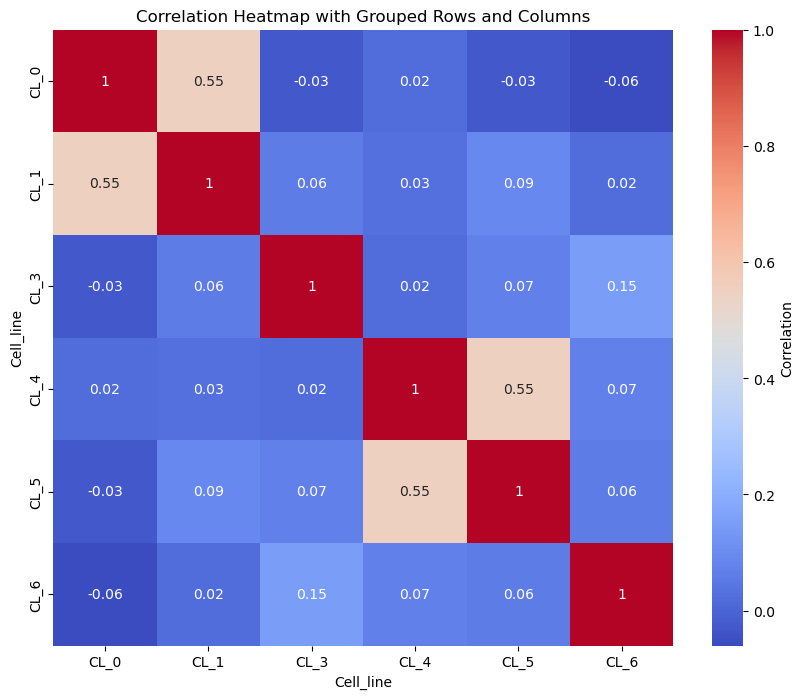

In [8]:
synthetic_data_long = synthetic_data_filtered.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time', value_name='Value')
pivot_data = synthetic_data_long.pivot_table(index=['Drug', 'Time', 'Signaling Node'], columns='Cell_line', values='Value').reset_index()

# Calculate Pearson correlation for each pair of cell lines
cell_lines = pivot_data.columns[3:]  # Skip the first three columns (Drug, Time, Signaling Node)
corr_data = pandas.DataFrame(index=cell_lines, columns=cell_lines)

for cell_line1 in cell_lines:
    for cell_line2 in cell_lines:
        if cell_line1 != cell_line2:
            corr, _ = pearsonr(pivot_data[cell_line1], pivot_data[cell_line2])
            corr_data.loc[cell_line1, cell_line2] = round(corr, 2)
        else:
            corr_data.loc[cell_line1, cell_line2] = 1.0

display(corr_data)
corr_data = corr_data.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap with Grouped Rows and Columns')
plt.show()

## Process Data to be Exported

Reformat `fullYFull` in order to have common Drug_CL_Time index and Genes as columns. Also, store mapping dataset (Drug_CL_Time -> Time point), so we can track which Drug_CL_Time maps to which Y time point when calculating the loss for the toy-model.

In [9]:
synthetic_data_melted = synthetic_data_filtered.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time point', value_name='Value')
synthetic_data_melted['Drug_CL_Time'] = synthetic_data_melted['Drug'].astype(str) + '_' + synthetic_data_melted['Cell_line'].astype(str) + '_' + synthetic_data_melted['Time point'].astype(str)
synthetic_data_pivoted = synthetic_data_melted.pivot(index='Drug_CL_Time', columns='Signaling Node', values='Value')
synthetic_data_final = synthetic_data_melted[['Drug_CL_Time', 'Time point']].drop_duplicates().set_index('Drug_CL_Time')
synthetic_data_final = synthetic_data_final.merge(synthetic_data_pivoted, left_index=True, right_index=True)

synthetic_data_melted_full = synthetic_data.reset_index().melt(id_vars=['Drug', 'Cell_line', 'Signaling Node'], var_name='Time point', value_name='Value')
synthetic_data_melted_full['Drug_CL_Time'] = synthetic_data_melted_full['Drug'].astype(str) + '_' + synthetic_data_melted_full['Cell_line'].astype(str) + '_' + synthetic_data_melted_full['Time point'].astype(str)
synthetic_data_pivoted_full = synthetic_data_melted_full.pivot(index='Drug_CL_Time', columns='Signaling Node', values='Value')
synthetic_data_final_full = synthetic_data_melted_full[['Drug_CL_Time', 'Time point']].drop_duplicates().set_index('Drug_CL_Time')
synthetic_data_final_full = synthetic_data_final_full.merge(synthetic_data_pivoted_full, left_index=True, right_index=True)

# Create a new mapping-dataset with Drug_CL_Time and Time point
condition_time_df = synthetic_data_final[['Time point']].reset_index()

synthetic_data_final.drop(columns=['Time point'], inplace=True)  # Delete Time point column from the synthetic dataset
synthetic_data_final_full.drop(columns=['Time point'], inplace=True)

display(condition_time_df.head())
display(synthetic_data_final.head())
display(synthetic_data_final_full.head())

,Drug_CL_Time,Time point
0,D_180_CL_0_1,1
1,D_180_CL_1_1,1
2,D_180_CL_3_1,1
3,D_180_CL_4_1,1
4,D_180_CL_5_1,1


,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D_180_CL_0_1,-0.066304,-0.021700,-0.041102,-0.000499,-0.037683,-0.048490,-0.033184,-0.037347,-0.051905,0.763318,...,-0.025333,-0.008988,-0.043714,-0.021938,-0.029380,-0.000006,0.942642,-0.076455,-0.044662,-0.001152
D_180_CL_1_1,-0.046451,-0.028734,-0.037784,-0.013592,-0.031370,-0.038980,-0.017405,-0.017068,-0.040431,-0.004524,...,-0.028517,-0.011833,-0.021756,-0.023500,-0.011728,-0.022071,0.811149,-0.052201,-0.039919,-0.002576
D_180_CL_3_1,-0.030298,-0.023050,0.046924,-0.030635,-0.051993,-0.026365,-0.014342,-0.016176,-0.044934,-0.026938,...,-0.004412,0.190452,-0.049604,-0.018947,-0.034572,-0.036202,-0.029651,-0.019453,-0.016817,-0.013120
D_180_CL_4_1,-0.002329,-0.051161,-0.016806,0.749670,-0.061174,0.218575,-0.040698,-0.038096,-0.011444,-0.010479,...,-0.042364,-0.014138,-0.003124,-0.013399,-0.031427,-0.030776,-0.025061,-0.005267,-0.042148,-0.016145
D_180_CL_5_1,0.012903,-0.042996,-0.024290,-0.002830,-0.038097,-0.006339,-0.020568,-0.036664,-0.030180,-0.012940,...,-0.025628,-0.001365,-0.009130,-0.031601,-0.022926,-0.017089,-0.037891,-0.021757,-0.033541,-0.016679


,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D_180_CL_0_0,-0.066264,-0.027248,-0.041102,-0.000315,-0.037680,-0.047656,-0.032695,-0.037347,-0.050841,0.763318,...,-0.025313,-0.011073,-0.046979,-0.021870,-0.029376,0.005990,0.926551,-0.068810,-0.044734,-0.000870
D_180_CL_1_0,-0.046273,-0.030646,-0.037784,-0.013302,-0.031369,-0.038502,-0.017069,-0.017068,-0.039591,-0.004524,...,-0.029098,-0.011508,-0.021377,-0.023457,-0.011598,-0.021323,0.611858,-0.047161,-0.039991,-0.002447
D_180_CL_3_0,-0.030094,-0.022705,0.046924,-0.030540,-0.052005,-0.025270,-0.014236,-0.016176,-0.044359,-0.026938,...,-0.004289,0.221821,-0.048966,-0.018847,-0.034273,-0.036231,-0.029555,-0.019697,-0.016816,-0.012998
D_180_CL_4_0,-0.002315,-0.050822,-0.016806,0.749968,-0.061171,0.316484,-0.039816,-0.038096,-0.010647,-0.010479,...,-0.042221,-0.013804,-0.005163,-0.013380,-0.038766,-0.030778,-0.024757,-0.005462,-0.042143,-0.015857
D_180_CL_5_0,-0.002950,-0.042724,-0.024290,-0.009138,-0.038094,-0.005663,-0.019939,-0.036664,-0.029519,-0.012940,...,-0.025481,-0.000825,-0.011453,-0.031543,-0.022837,-0.017159,-0.037808,-0.022066,-0.033536,-0.016402


In [10]:
'''# Expand X based on time
X_filtered['Condition'] = X_filtered.index
X_final = X_filtered.loc[X_filtered.index.repeat(dim3)].reset_index(drop=True)
X_final['Time point'] = numpy.tile(range(dim3), dim1)
X_final['Condition_Time'] = X_final['Condition'].astype(str) + '_' + X_final['Time point'].astype(str)
X_final.set_index('Condition_Time', inplace=True)
X_final.drop(columns=['Condition', 'Time point'], inplace=True)

X_final = X_final.loc[synthetic_data_final.index]'''
X_final = X_filtered.copy()
X_final['Drug_CL'] = X_final.index.get_level_values('Drug') + '_' + X_final.index.get_level_values('Cell_line')
X_final.set_index('Drug_CL', inplace=True)
X_final.index.name = 'Drug_CL'
display(X_final.head())

X_cell_final = X_cell.copy()
X_cell_final['Drug_CL'] = X_cell_final.index.get_level_values('Drug') + '_' + X_cell_final.index.get_level_values('Cell_line')
X_cell_final.set_index('Drug_CL', inplace=True)
X_cell_final.index.name = 'Drug_CL'
display(X_cell_final.head())

,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug_CL,,,,,,,,,,,,,,,,,,,,,
D_180_CL_0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_180_CL_1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_180_CL_3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_180_CL_4,0.0,0.0,0.0,0.0,0.0,0.0,0.855909,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_180_CL_5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cell_line,CL_0,CL_1,CL_3,CL_4,CL_5,CL_6
Drug_CL,,,,,,
D_180_CL_0,1,0,0,0,0,0
D_180_CL_1,0,1,0,0,0,0
D_180_CL_3,0,0,1,0,0,0
D_180_CL_4,0,0,0,1,0,0
D_180_CL_5,0,0,0,0,1,0


## Export Data

In [11]:
synthetic_data_final.to_csv('data/synthetic_data_y.csv', index=True)
synthetic_data_final_full.to_csv('data/synthetic_data_y_full.csv', index=True)
X_final.to_csv('data/synthetic_data_x.csv', index=True)
X_cell_final.to_csv('data/synthetic_data_xcell.csv', index=True)
condition_time_df.to_csv('data/synthetic_data_xtime.csv', index=True)
b_celltype.to_csv('data/b_celltype.csv', index=True)